In [1]:
import os
from glob import glob
from typing import Optional, Union, Tuple

import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.util import get_random_colors
from torch_em.data.datasets.electron_microscopy.lucchi import get_lucchi_paths
from torch_em.data.datasets.light_microscopy.covid_if import get_covid_if_data

from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel, threshold_sauvola
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion, distance_transform_edt
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
import cv2
import re
from matplotlib.ticker import MaxNLocator
import imageio.v2 as imageio  # or use `from imageio import imwrite` if you prefer
from huggingface_hub import hf_hub_download
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import pathlib

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
def run_automatic_instance_segmentation(
    image: np.ndarray,
    checkpoint_path: Union[os.PathLike ,str],
    model_type: str = "vit_b_lm",
    device: Optional[Union[str, torch.device]] = None,
    tile_shape: Optional[Tuple[int, int]] = None,
    halo: Optional[Tuple[int, int]] = None,
):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.
        tile_shape: The tile shape for tiling-based segmentation.
        halo: The overlap shape on each side per tile for stitching the segmented tiles.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        is_tiled=(tile_shape is not None),  # whether to run automatic segmentation.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,  # the filepath to image or the input array for automatic segmentation.
        ndim=2,  # the number of input dimensions.
        tile_shape=tile_shape,  # the tile shape for tiling-based prediction.
        halo=halo,  # the overlap shape for tiling-based prediction.
    )

    return prediction

In [3]:
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()


def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1], image[2]

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sj1205\.cache\huggingface\hub\models--sunny17347--machine_learning_models. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_datase

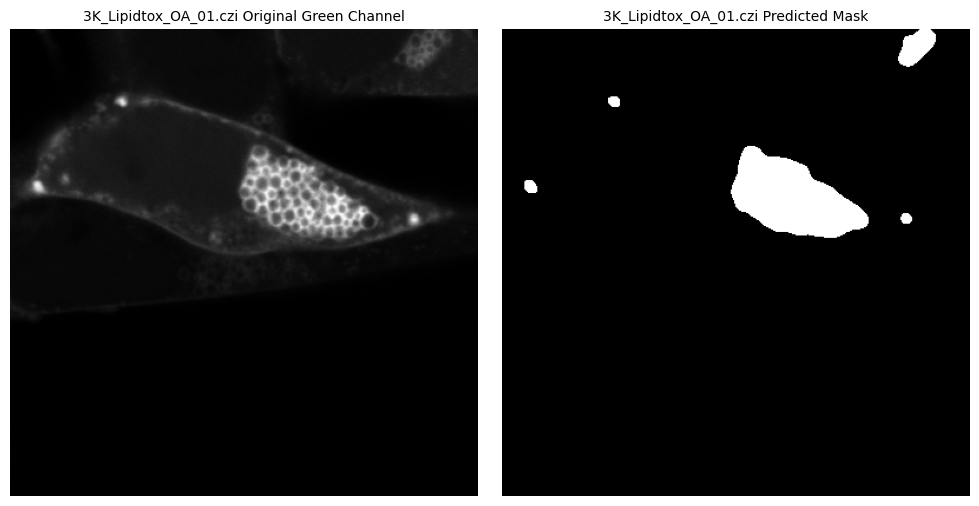

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


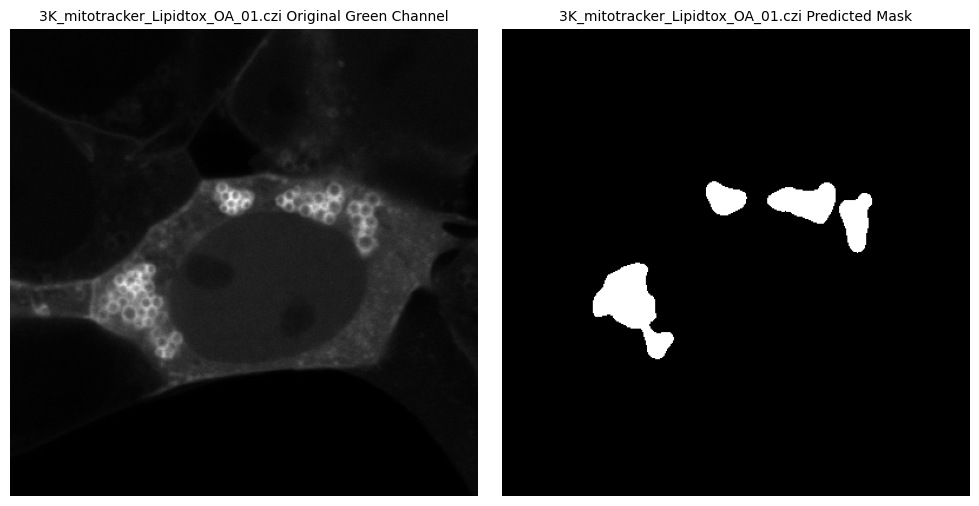

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


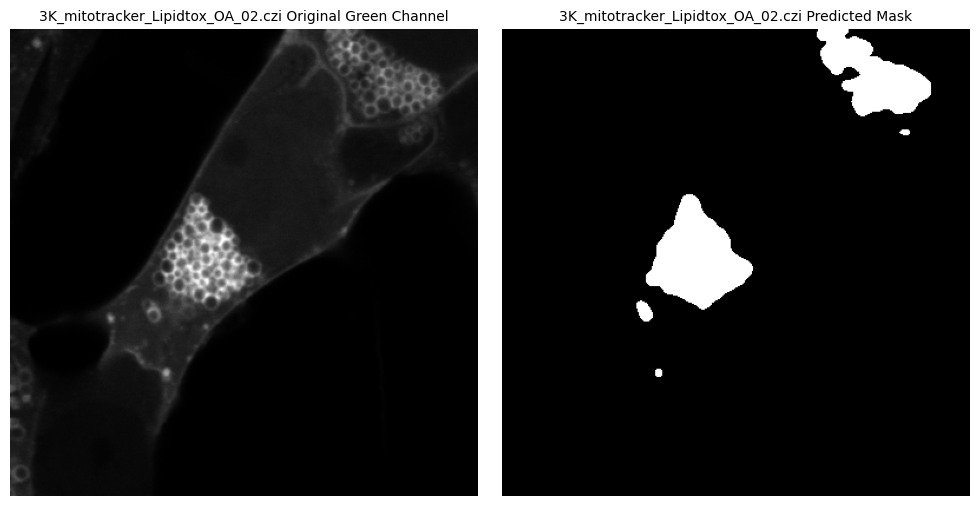

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


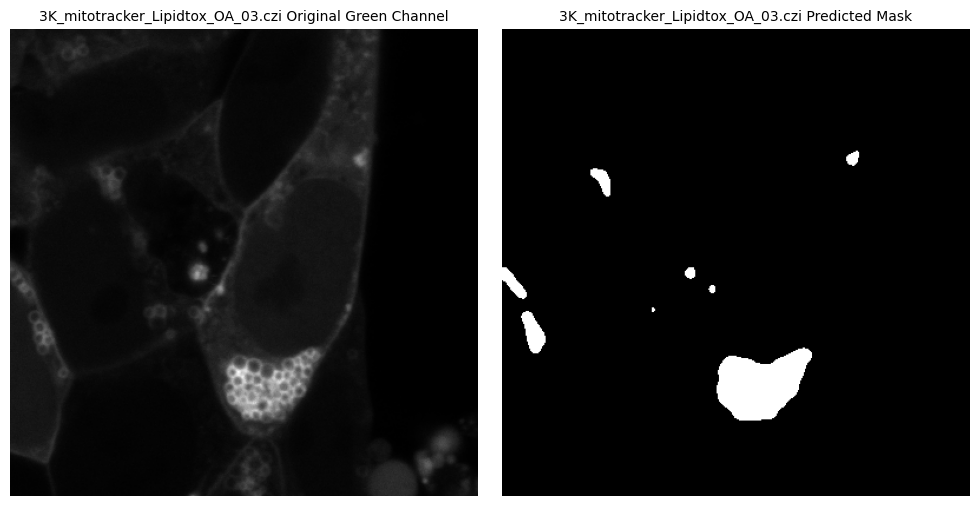

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


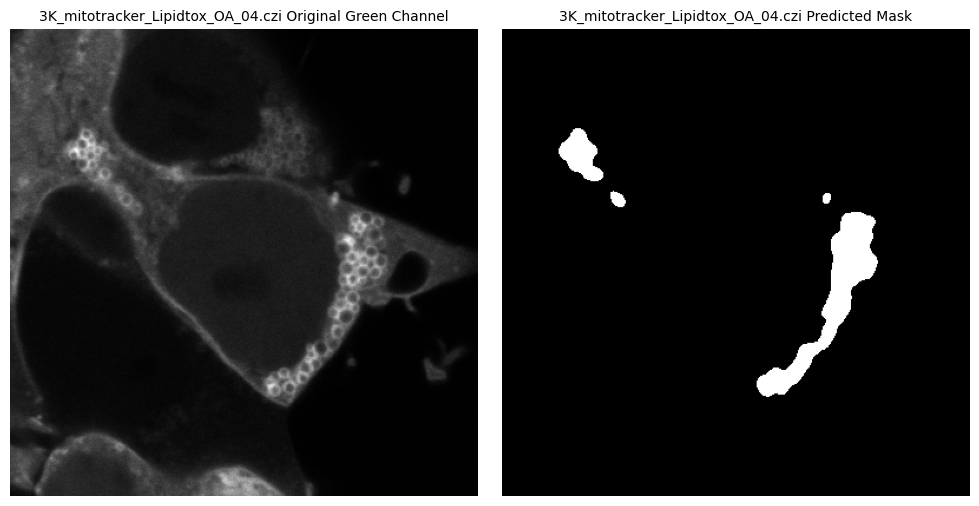

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


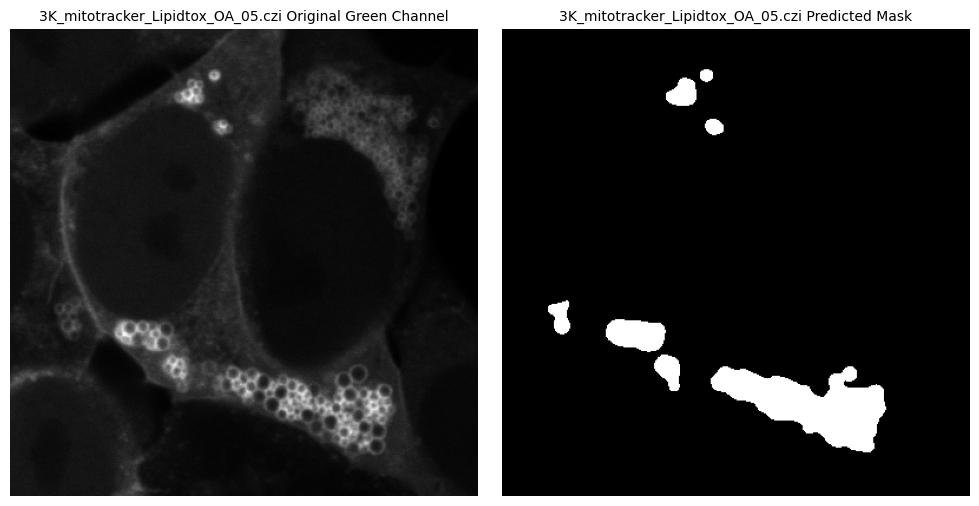

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


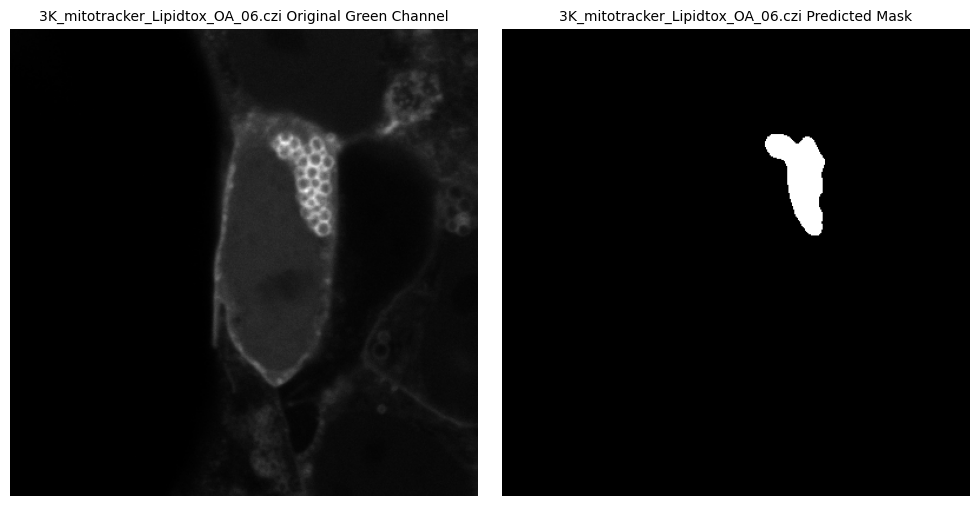

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


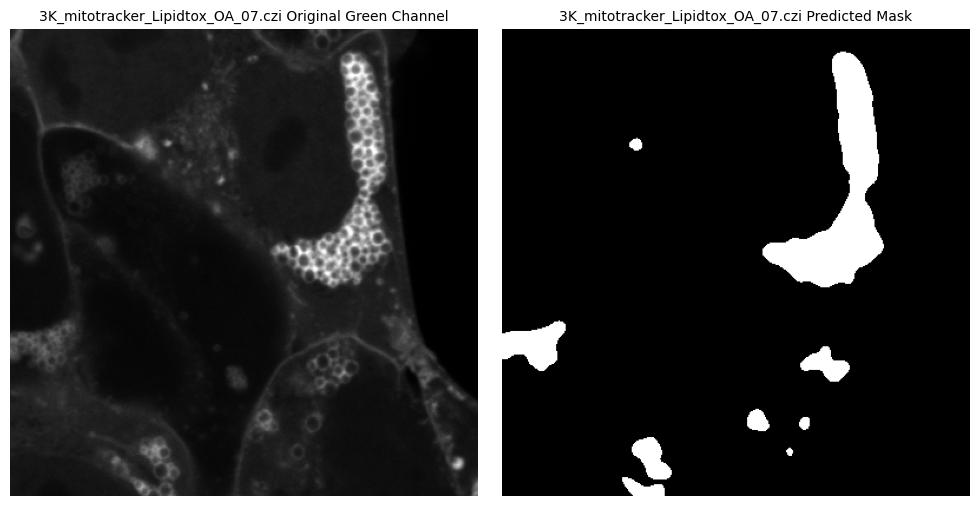

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


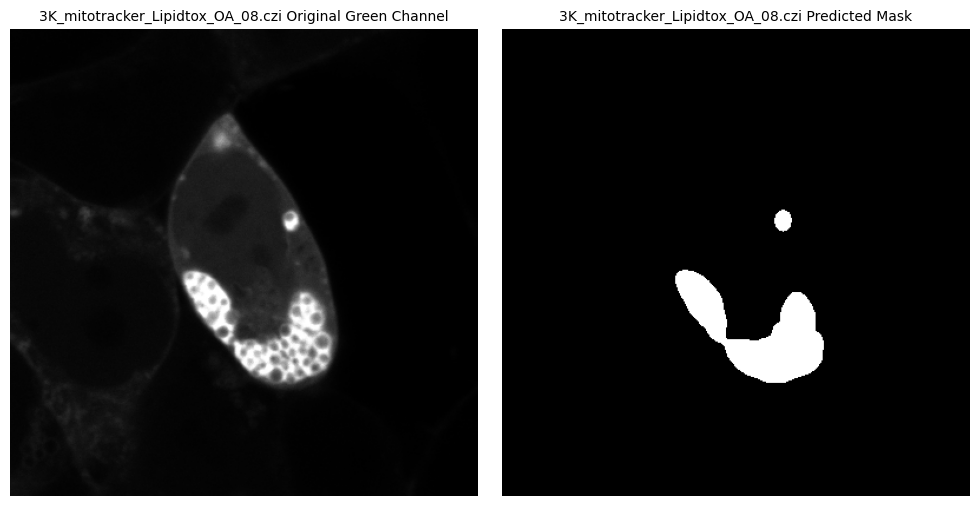

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


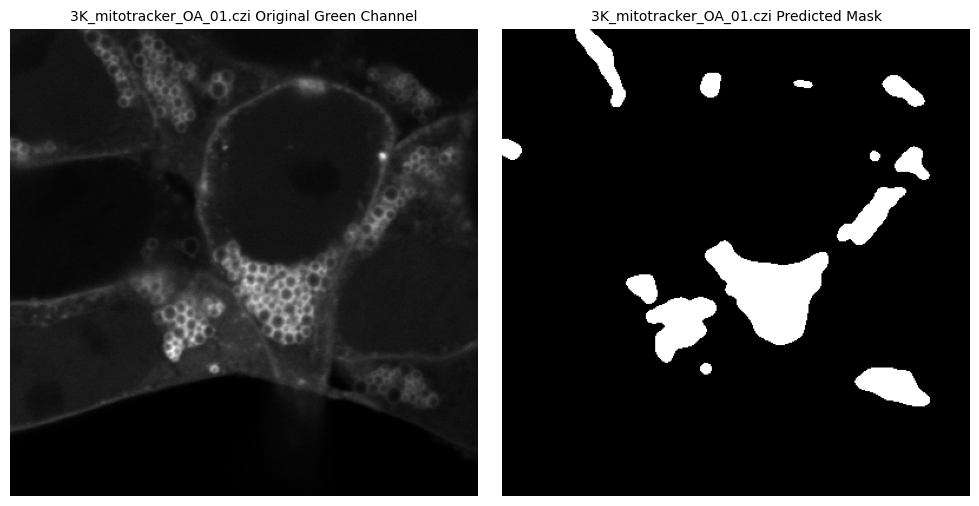

In [4]:
# Configuration
MODEL_TYPE   = "vit_b_lm"
CHECKPOINT = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="SAM_finetuned.pt")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def main(image_folder: str) -> None:

    output_dir = "images/micro_sam_predictions"
    os.makedirs(output_dir, exist_ok=True)  # <- create once

    predictor, segmenter = get_predictor_and_segmenter(
        model_type=MODEL_TYPE,
        checkpoint=CHECKPOINT,
        device=DEVICE,
        is_tiled=False,
    )

    for path in extract_image_paths(image_folder):
        image = read_image(path)
        red, orange, green = extract_channels(np.squeeze(image))

        mask = automatic_instance_segmentation(
            predictor=predictor,
            segmenter=segmenter,
            input_path=green,
            ndim=2,
        ) > 0

        mask_uint8 = mask.astype(np.uint8) * 255

        display_two_images(
            image1=green,
            image2=mask_uint8,
            title1="Original Green Channel",
            title2="Predicted Mask",
            path=path,
        )

        plt.close()

        #filename = os.path.splitext(os.path.basename(path))[0]  # Use only base name
        #for prefix in ["3K_dox_LTX_farred_", "3K_dox_LTX_farred_", "3K_dox_LTX_farred_"]:
        #    if filename.startswith(prefix):
        #        filename = filename[len(prefix):]
        #        break
        #save_path = os.path.join(output_dir, f"{filename}.png")
#
        #imageio.imwrite(save_path, mask_uint8)

if __name__ == "__main__":
    image_folder = 'images/yiming_images'  
    main(image_folder)